### ***Content based filtering***

Content-based filtering recommends items similar to what a user liked before, based on item features rather than other users’ preferences.

For example, if a user liked a movie with certain attributes (genre, actors, director), the system recommends movies with similar attributes.

It uses item metadata to find similarities and make recommendations.

This approach is effective when user interaction data is sparse, as it relies on item characteristics.

However, it may lead to over-specialization, where users are only recommended items similar to their past preferences, limiting diversity.

Content-based filtering is commonly used in recommendation systems for movies, music, books, and e-commerce products.

Core Idea

Each item (movie, book, product, etc.) has descriptive features — genre, author, keywords, etc.
Each user has a profile built from the features of items they’ve liked.
The system recommends new items with high similarity to the user’s profile.

***Convert text to feature vectors***

Why “Convert Text to Feature Vectors” Is Crucial

In content-based filtering, your data (movie plot, product description, etc.) is in text form —
but machine learning models and similarity functions (like cosine similarity) can’t work on raw text.

They need numerical representations — that’s what “feature vectors” are.

| Movie        | Description                                                            |
| ------------ | ---------------------------------------------------------------------- |
| Inception    | A thief who steals corporate secrets through dream-sharing technology. |
| Interstellar | A team travels through a wormhole to save humanity.                    |

Humans can see these are similar (both sci-fi, space/time themes).
But the computer sees just text — it needs numbers to compare.

After vectorization using TF-IDF or CountVectorizer, you get:

| Word     | Inception | Interstellar |
| -------- | --------- | ------------ |
| thief    | 0.4       | 0.0          |
| dream    | 0.3       | 0.0          |
| wormhole | 0.0       | 0.4          |
| humanity | 0.0       | 0.3          |


TF-IDF vs CountVectorizer

| Feature      | **CountVectorizer**                        | **TF-IDF Vectorizer**                         |
| ------------ | ------------------------------------------ | --------------------------------------------- |
| What it does | Counts word occurrences                    | Weights words by importance                   |
| Effect       | Frequent words dominate (like “the”, “is”) | Common words are down-weighted                |
| When to use  | Small datasets or categorical tags         | Real text data (plots, reviews, descriptions) |
| Output       | Sparse matrix of counts                    | Sparse matrix of normalized weights           |


***Item similarity matrix - Use cosine similarity between all item vectors***

Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. It is often used in high-dimensional positive spaces, such as text analysis, to determine how similar two documents are based on their word vectors.

```math
cosine similarity = A · B / (||A|| ||B||)
```

where A and B are vectors, · denotes the dot product, and ||A|| and ||B|| are the magnitudes (lengths) of the vectors.

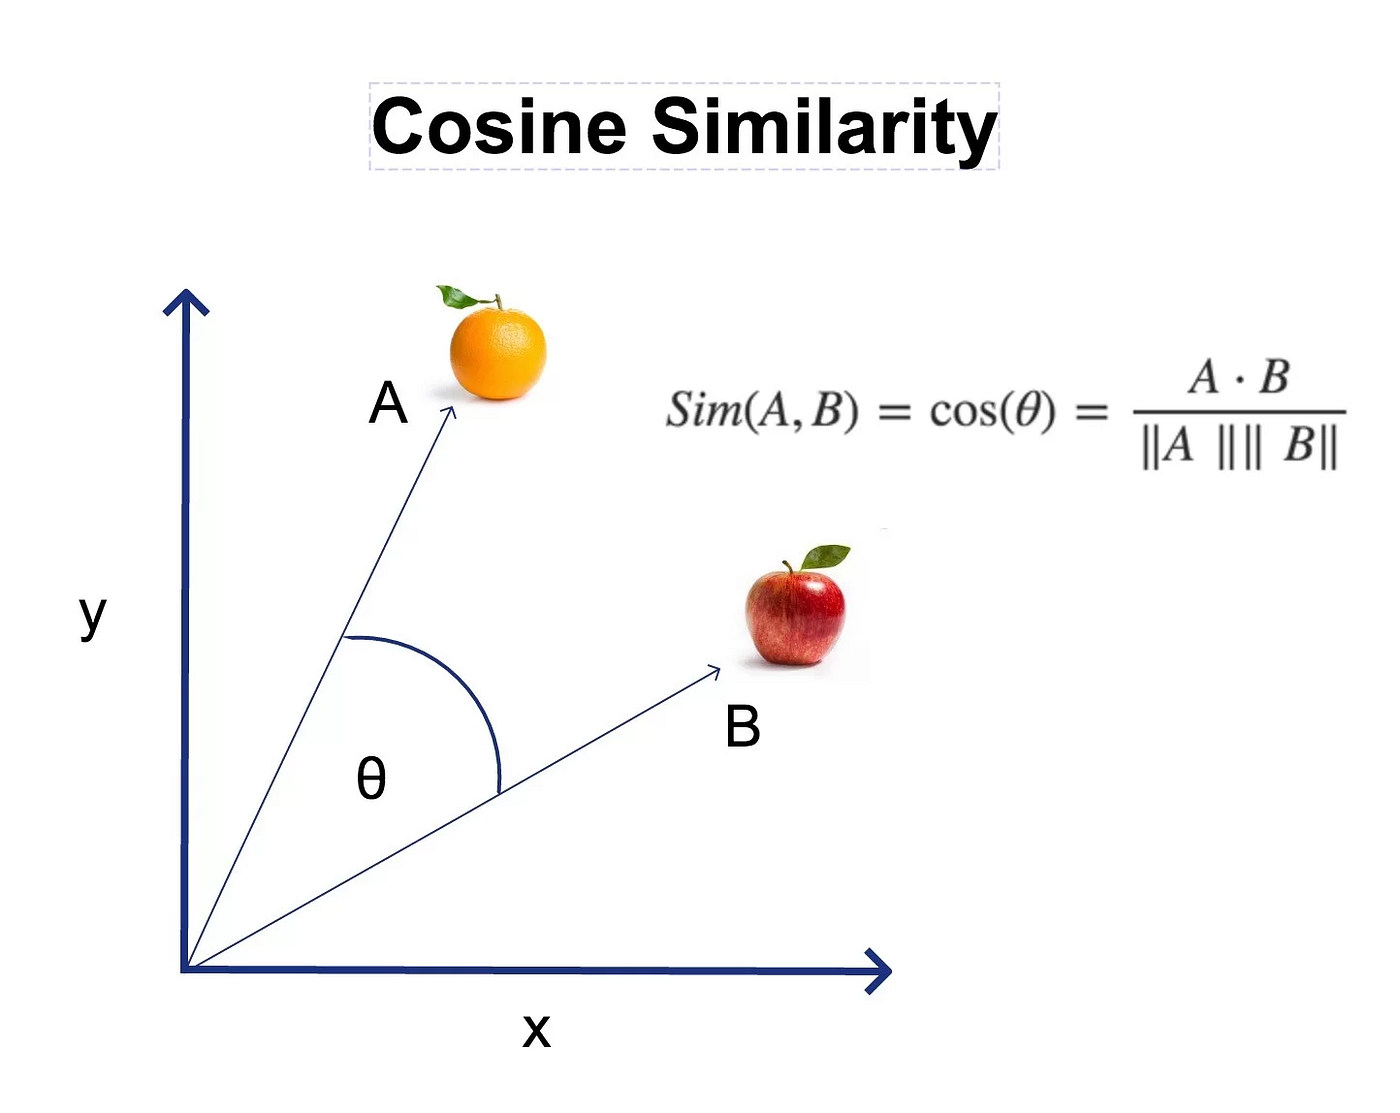

In [ ]:
# implementation of a content based filtering recommendation system using TF-IDF and cosine similarity

# using movie dataset with movie titles and plots
# recommend movies based on plot similarity
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# load movie dataset
movies = pd.read_csv('movies.csv')  # Assume movies.csv has 'title' and

# 'plot' columns
# display first few rows
print(movies.head())

# split dataset into train and test sets
train_data, test_data = train_test_split(movies, test_size=0.2, random_state=42)
print(f'Train data shape: {train_data.shape}, Test data shape: {test_data.shape}')

# create TF-IDF vectorizer
tfidf = TfidfVectorizer(stop_words='english')
# fit and transform the plot data
tfidf_matrix = tfidf.fit_transform(train_data['plot'])
print(f'TF-IDF matrix shape: {tfidf_matrix.shape}')

# compute cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print(f'Cosine similarity matrix shape: {cosine_sim.shape}')

# create a mapping from movie titles to indices
indices = pd.Series(train_data.index, index=train_data['title']).drop_duplicates()
print(indices.head())

# function to get movie recommendations based on title
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]  # get top 10 similar movies
    movie_indices = [i[0] for i in sim_scores]
    return train_data['title'].iloc[movie_indices]

***Content-based filtering implementation steps***

1. Project setup
    - Create virtualenv; pin package versions.
    - Import libraries (pandas, numpy, sklearn, joblib, optionally sentence-transformers or faiss).

2. Load & inspect dataset
    - Load CSV/JSON and confirm required columns (title, description/plot, genre, metadata).
    - Quick EDA: shape, head(), dtypes, missing values, duplicates.

3. Clean & preprocess text
    - Basic cleaning: lowercase, strip, remove punctuation, normalize whitespace.
    - Optionally remove stopwords, lemmatize, normalize genres/tags.

4. Combine fields into a single content string
    - Merge title + genre + description + tags into one text column used for vectorization.

5. Vectorization / embeddings
    - Choose representation: TF-IDF (fast, sparse) or sentence/transformer embeddings (semantic).
    - Fit vectorizer/encoder on the item corpus (training set or full catalog if static).

6. Build item vectors & normalize
    - Transform texts → vectors and L2-normalize (for cosine similarity).

7. Similarity computation
    - Compute item-item similarity using cosine similarity.
    - For large catalogs use ANN (Faiss/Annoy/hnswlib) or NearestNeighbors with sparse support.

8. Recommendation function
    - Map title → index robustly (handle duplicates).
    - For a query item, return top-N most similar items (exclude the item itself).
    - Optionally filter by metadata (language, year) or minimum similarity threshold.
    - Return titles and similarity scores; optionally top contributing terms for explainability.

9. Evaluation (offline)
    - Use holdout test set and metrics like precision@K, recall@K, MAP, NDCG, hit rate.
    - Check diversity/novelty as needed.

10. Persist & deploy
     - Save artifacts: vectorizer/encoder, item vectors/index, title→index mapping (joblib/pickle).
     - Expose as API or batch job; use ANN for low-latency lookups and cache popular queries.

Quick checklist
- Exclude self-recommendation, handle missing plots, deduplicate titles.
- Fix random_state where applicable and version artifacts.
- Start with TF-IDF + cosine; iterate to embeddings and ANN if quality/scale require it.
